In [1]:
import torch
import torch.nn as nn
import pandas as pd
import math
import random
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

t = 0.5
seed = 42
MAX_EPOCHS = int(1e6)

# problem setup: min( ||p*a - t||^2 + \lambda*\sum{(p_i)*(1-p_i)*a_i^2})

def get_regularization(n, p, a, i=0):
    reg = torch.sum(p * (1-p) * torch.pow(a, 2))
    if i == 0:
        lmbda = 1.0
    elif i == 1:
        lmbda = 1.0/(n**math.log(n))
    elif i == 2:
        lmbda = 1.0/n
    elif i == 3:
        lmbda = 1/n**2
    else:
        lmbda = i
    
    reg = lmbda * reg
    return reg

def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    print("Seeded everything: {}".format(seed))
    
set_seed(seed)

Seeded everything: 42


In [2]:
# decide regularizer

def subset_sum(num_samples=10, regularizer=0):
    a = torch.zeros(num_samples)
    p = nn.Parameter(torch.Tensor(a.size()))
    a.requires_grad = False
    p_list = []
    tot_loss_list = []
    subset_loss_list = []
    epoch_list = []

    optimizer = optim.Adam(
                [p],
                lr=0.01,
                weight_decay=0)

    # initialize a as uniform [-1, 1]
    nn.init.uniform_(a, a=-1, b=1)
    nn.init.normal_(p, mean=0.5)
    p.data = torch.clamp(p.data, 0.0, 1.0)

    for num_iter in range(MAX_EPOCHS):
        optimizer.zero_grad()
        loss = (t - torch.sum(p*a))**2 + get_regularization(num_samples, p, a, i=regularizer)
        loss.backward()
        optimizer.step()
        # loss we care out is not the total loss. Just the subset sum loss
        subset_loss_list.append(((t - torch.sum(p*a))**2).item())
        # also remember total loss for stopping criterion
        tot_loss_list.append(loss.item())
        epoch_list.append(num_iter)
        p_list.append(p.data)
        if num_iter % 100000 == 0 and num_iter != 0:
            print("Iteration={} | Loss={}".format(num_iter, loss))
        p.data = torch.clamp(p.data, 0.0, 1.0)
        if num_iter > 5 and loss.item() == tot_loss_list[-2]:
            # print("Iteration={} | Converged".format(num_iter))
            break
        
    min_error = (1.0/num_samples)**np.log(num_samples)
    # print("Minimum Error = {}".format(min_error))
    results_df = pd.DataFrame({'epoch': epoch_list, 'loss': subset_loss_list})
    return min_error, p, results_df

# returns number of vertices which are fractional
def get_num_frac(x, num_samples):
    num_middle = torch.sum(torch.gt(x,
                           torch.ones_like(x)*0) *
                           torch.lt(x,
                           torch.ones_like(x*(1)).int())).item()
    return 1.0*num_middle/num_samples

# returns l2 distance to the nearest vertex
def get_dist_to_vertex(x):
    rounded_x = torch.gt(x, torch.ones_like(x)*0.5).int().float()
    return torch.norm(x-rounded_x).item()

In [3]:
avg_error_ratios = []
for num_samples in [1e2, 1e3,]:
    print("Num Samples = {}".format(num_samples))
    error_ratio_list = []
    for i in range(1):
        for reg in range(5):
            num_samples = int(num_samples)
            min_error, p_final, results_df = subset_sum(num_samples, reg)
            final_error = results_df.tail(1).loss.item()
            num_frac = get_num_frac(p_final, num_samples)
            dist_to_vertex = get_dist_to_vertex(p_final)
            print("Regularizer = {} | Error_ratio={} | Final error={} | Minimum error={} | num_frac={} | dist_to_veretx={}".\
                  format(reg, final_error/min_error, final_error, min_error, num_frac, dist_to_vertex))
            error_ratio = final_error/min_error
            error_ratio_list.append(error_ratio)
        avg_error_ratio = 1.0*sum(error_ratio_list)/len(error_ratio_list)
        avg_error_ratios.append(avg_error_ratio)

Num Samples = 100.0
Regularizer = 0 | Error_ratio=7542664.936514222 | Final error=0.004647125955671072 | Minimum error=6.161119438269389e-10 | num_frac=0.0 | dist_to_veretx=0.0
Regularizer = 1 | Error_ratio=9.477125471661099 | Final error=5.8389701962369145e-09 | Minimum error=6.161119438269389e-10 | num_frac=1.0 | dist_to_veretx=2.3295340538024902
Regularizer = 2 | Error_ratio=511205.31975046615 | Final error=0.00031495970324613154 | Minimum error=6.161119438269389e-10 | num_frac=0.02 | dist_to_veretx=0.5726650357246399
Regularizer = 3 | Error_ratio=2183927.2391644246 | Final error=0.0013455436564981937 | Minimum error=6.161119438269389e-10 | num_frac=0.01 | dist_to_veretx=0.02385825477540493
Regularizer = 4 | Error_ratio=848060.3924372741 | Final error=0.0005225001368671656 | Minimum error=6.161119438269389e-10 | num_frac=0.01 | dist_to_veretx=0.49992960691452026
Num Samples = 1000.0
Regularizer = 0 | Error_ratio=2.137442158315271e+18 | Final error=0.004042299930006266 | Minimum erro

In [4]:
num_samples = 100
min_error_list = []
error_list = []
lmbda_list = []
num_frac_list = []
dist_to_vertex_list = []
error_ratio_list = []

for lmbda in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0]:
    min_error, p_final, results_df = subset_sum(num_samples, lmbda)
    final_error = results_df.tail(1).loss.item()
    num_frac = get_num_frac(p_final, num_samples)
    dist_to_vertex = get_dist_to_vertex(p_final)
    print("Lambda = {} | Error_ratio={} | Final error={} | Minimum error={} | Num fractional coordinates={} | dist_to_veretx={}".\
          format(lmbda, final_error/min_error, final_error, min_error, num_frac, dist_to_vertex))
    error_list.append(final_error)
    min_error_list.append(min_error)
    num_frac_list.append(num_frac)
    dist_to_vertex_list.append(dist_to_vertex)
    lmbda_list.append(lmbda)
    error_ratio_list.append(final_error/min_error)

Lambda = 1e-06 | Error_ratio=0.17659429833067308 | Final error=1.0880185641326534e-10 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=1.0 | dist_to_veretx=2.074002265930176
Lambda = 1e-05 | Error_ratio=0.08442504887704112 | Final error=5.2015280971318134e-11 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=1.0 | dist_to_veretx=1.7375987768173218
Lambda = 0.0001 | Error_ratio=1542079.5254123025 | Final error=0.0009500936139374971 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.01 | dist_to_veretx=0.472167432308197
Iteration=100000 | Loss=1.1880521455509552e-08
Lambda = 0.001 | Error_ratio=978194.2705141767 | Final error=0.0006026771734468639 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.01 | dist_to_veretx=0.0050104898400604725
Lambda = 0.01 | Error_ratio=135065.53778913777 | Final error=8.321549103129655e-05 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.01 | dist_to_veretx=0.23925790

In [10]:
results_df = pd.DataFrame({"lambda": lmbda_list, "error": error_list,
                          "num_frac": num_frac_list, "dist_to_vertex": dist_to_vertex_list,
                          "min_error": min_error_list, "error_ratio": error_ratio_list})

In [20]:
results_df['log_error'] = np.log(results_df['error'])
results_df['log_lambda'] = np.log(results_df['lambda'])
results_df['log_min_error'] = np.log(results_df['min_error'])

/Users/kartik/ml_workspace/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log_lambda', ylabel='log_error'>

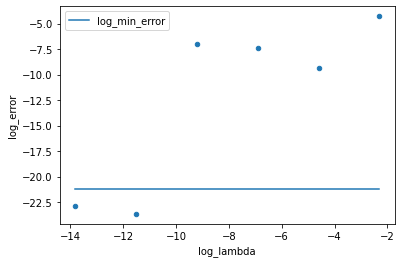

In [22]:
ax = results_df.plot(x="log_lambda", y="log_error", kind='scatter')
results_df.plot(x="log_lambda", y="log_min_error", ax=ax)

<AxesSubplot:xlabel='log_lambda', ylabel='num_frac'>

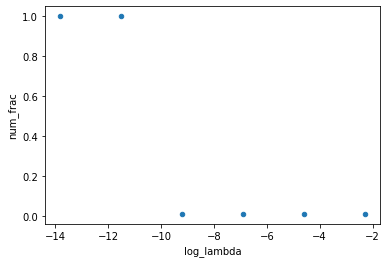

In [23]:
results_df.plot(x="log_lambda", y="num_frac", kind="scatter")

<AxesSubplot:xlabel='log_lambda', ylabel='dist_to_vertex'>

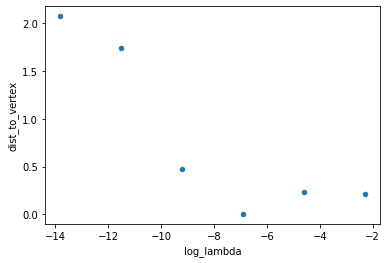

In [24]:
results_df.plot(x="log_lambda", y="dist_to_vertex", kind="scatter")

# Binary search to find optimal lambda (if it exists)

In [4]:
num_samples = 100
min_error_list = []
error_list = []
lmbda_list = []
num_frac_list = []
dist_to_vertex_list = []
error_ratio_list = []
l_min = 1e-5
l_max = 1e-4

for i in range(10):
    lmbda = (l_min + l_max)/2
    min_error, p_final, results_df = subset_sum(num_samples, lmbda)
    final_error = results_df.tail(1).loss.item()
    num_frac = get_num_frac(p_final, num_samples)
    dist_to_vertex = get_dist_to_vertex(p_final)
    print("Lambda = {} | Error_ratio={} | Final error={} | Minimum error={} | Num fractional coordinates={} | dist_to_veretx={}".\
          format(lmbda, final_error/min_error, final_error, min_error, num_frac, dist_to_vertex))
    error_list.append(final_error)
    min_error_list.append(min_error)
    num_frac_list.append(num_frac)
    dist_to_vertex_list.append(dist_to_vertex)
    lmbda_list.append(lmbda)
    error_ratio_list.append(final_error/min_error)
    if final_error < min_error or num_frac > 0.5:
        l_min = lmbda
    else:
        l_max = lmbda

Lambda = 5.5e-05 | Error_ratio=5017602.635312105 | Final error=0.003091404912993312 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.01 | dist_to_veretx=0.0238798800855875
Iteration=100000 | Loss=7.93205344962189e-06
Lambda = 3.2500000000000004e-05 | Error_ratio=308.29958885512036 | Final error=1.899470589705743e-07 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.06 | dist_to_veretx=0.5977756977081299
Lambda = 2.125e-05 | Error_ratio=13.357644622832028 | Final error=8.2298043935225e-09 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=1.0 | dist_to_veretx=1.7004562616348267
Iteration=100000 | Loss=0.0001420225016772747
Iteration=200000 | Loss=9.130993561257128e-08
Lambda = 2.6875000000000003e-05 | Error_ratio=11144.368289937545 | Final error=6.866178409836721e-06 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.04 | dist_to_veretx=0.41415953636169434
Lambda = 2.4062500000000002e-05 | Error_ratio=17.1385905382

<AxesSubplot:xlabel='log_lambda', ylabel='log_error'>

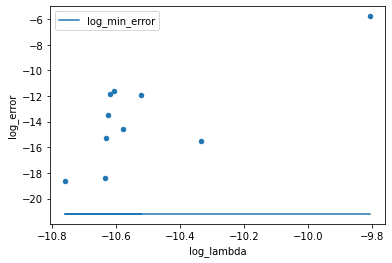

In [5]:
results_df = pd.DataFrame({"lambda": lmbda_list, "error": error_list,
                          "num_frac": num_frac_list, "dist_to_vertex": dist_to_vertex_list,
                          "min_error": min_error_list, "error_ratio": error_ratio_list})
results_df['log_error'] = np.log(results_df['error'])
results_df['log_lambda'] = np.log(results_df['lambda'])
results_df['log_min_error'] = np.log(results_df['min_error'])

ax = results_df.plot(x="log_lambda", y="log_error", kind='scatter')
results_df.plot(x="log_lambda", y="log_min_error", ax=ax)

<AxesSubplot:xlabel='log_lambda', ylabel='num_frac'>

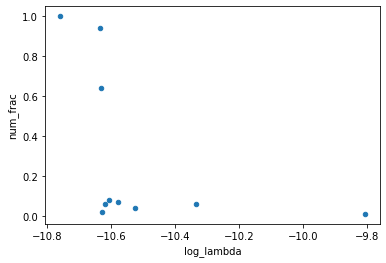

In [6]:
results_df.plot(x="log_lambda", y="num_frac", kind="scatter")

<AxesSubplot:xlabel='log_lambda', ylabel='dist_to_vertex'>

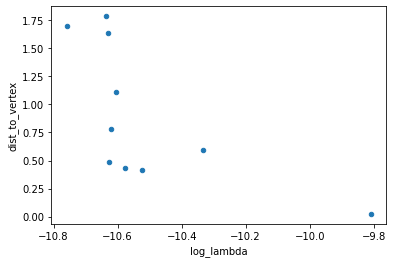

In [7]:
results_df.plot(x="log_lambda", y="dist_to_vertex", kind="scatter")

## $2.5\cdot10^{-5}$ doesn't look too bad!